In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from fit_func import load_helper, double_peak_fit
from mos2_rfit import mos2_fit
import torch
import torch.multiprocessing as mp
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

device = torch.device("mps")
dtype = torch.float32
learning_rate = 0.1
learning_rounds = 40

class Lorentizian(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        return 1/ (input ** 2 +1)

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        return - (grad_output * 2 * input / ((1 + input **2 ) **2))

class RamanTwoPeaks(torch.nn.Module):
    def __init__(self, 
                 pixels, 
                 x_coordinates_len,
                 peak_0_amplitude_guess,
                 peak_0_center_guess,
                 peak_0_sigma_guess,
                 peak_1_amplitude_guess,
                 peak_1_center_guess,
                 peak_1_sigma_guess,
                 slope_guess,
                 constant_guess,
                 Lorentizian_function=Lorentizian.apply):
        
        super().__init__()
        
        self.pixels, self.x_coordinates_len = (pixels, x_coordinates_len)

        self.peak_0_amplitudes = torch.tensor(
            peak_0_amplitude_guess * np.ones(self.pixels).reshape(-1,1),
                    device=device, dtype=dtype, requires_grad=True)
        self.peak_0_centers = torch.tensor(
            peak_0_center_guess * np.ones(self.pixels).reshape(-1,1),
                    device=device, dtype=dtype, requires_grad=True)
        self.peak_0_sigmas = torch.tensor(
            peak_0_sigma_guess * np.ones(self.pixels).reshape(-1,1),
                    device=device, dtype=dtype, requires_grad=True)
        self.peak_1_amplitudes = torch.tensor(
            peak_1_amplitude_guess * np.ones(self.pixels).reshape(-1,1),
                    device=device, dtype=dtype, requires_grad=True)
        self.peak_1_centers = torch.tensor(
            peak_1_center_guess * np.ones(self.pixels).reshape(-1,1),
                    device=device, dtype=dtype, requires_grad=True)
        self.peak_1_sigmas = torch.tensor(
            peak_1_sigma_guess * np.ones(self.pixels).reshape(-1,1),
                    device=device, dtype=dtype, requires_grad=True)
        self.slopes = torch.tensor(
            slope_guess * np.ones(self.pixels).reshape(-1,1),
                    device=device, dtype=dtype, requires_grad=True)
        self.constants = torch.tensor(
            constant_guess * np.ones(self.pixels).reshape(-1,1),
                    device=device, dtype=dtype, requires_grad=True)
        self.train_parameters = [
                                                       self.peak_0_amplitudes, 
                                                       self.peak_0_centers, 
                                                       self.peak_0_sigmas,
                                                       self.peak_1_amplitudes,
                                                       self.peak_1_centers,
                                                       self.peak_1_sigmas,
                                                       self.slopes,
                                                       self.constants
                                                       ]

        self.LP = Lorentizian_function

    def forward(self, x):

        result = (self.constants.repeat(1, self.x_coordinates_len) 
              + torch.matmul(torch.diag(self.slopes.reshape(-1)), x)
              + torch.matmul(torch.diag(self.peak_0_amplitudes.reshape(-1)),
                self.LP((x - self.peak_0_centers.repeat(1,self.x_coordinates_len))/self.peak_0_sigmas.repeat(1,self.x_coordinates_len)))
              + torch.matmul(torch.diag(self.peak_1_amplitudes.reshape(-1)),
                self.LP((x - self.peak_1_centers.repeat(1,self.x_coordinates_len))/self.peak_1_sigmas.repeat(1,self.x_coordinates_len)))
                )
        return result



In [2]:
x_input, y_input = load_helper('spectrums.txt')
height, width, _ = y_input.shape
mos2_range = (x_input < 450.0) & (x_input > 350.0)
pixels = 40 * width
x_raw = x_input[mos2_range]
y = y_input.reshape(-1,1340)[:pixels, mos2_range]

x = torch.tensor(x_raw.reshape(1,-1), 
                 device=device, 
                 dtype=dtype).repeat(pixels,1)
y = torch.tensor(y,  
                 device=device, 
                 dtype=dtype)

initial_fit_params, _ = double_peak_fit(np.mean(y_input, axis=(0,1))[mos2_range], x_input[mos2_range])
init_params = {
    'peak_0_amplitude_guess':
    initial_fit_params['peak_0_amplitude']/(np.pi * initial_fit_params['peak_0_sigma']),
    'peak_0_center_guess':initial_fit_params['peak_0_center'],
    'peak_0_sigma_guess':initial_fit_params['peak_0_sigma'],
    'peak_1_amplitude_guess':
    initial_fit_params['peak_1_amplitude']/(np.pi * initial_fit_params['peak_1_sigma']),
    'peak_1_center_guess':initial_fit_params['peak_1_center'],
    'peak_1_sigma_guess':initial_fit_params['peak_1_sigma'],
    'slope_guess':initial_fit_params['_slope'],
    'constant_guess':initial_fit_params['_intercept'],}


model = RamanTwoPeaks(pixels=pixels,
                      x_coordinates_len=np.sum(mos2_range),
                      **init_params)

training_indices = tqdm(range(learning_rounds))
optimizer = torch.optim.RMSprop(model.train_parameters, lr=learning_rate)

for t in training_indices:
    y_pred =  model(x)
    # Compute and print loss
    loss = (y_pred - y).pow(2).sum()
    training_indices.set_description(f'Loss {loss.item()/1E9} ')
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

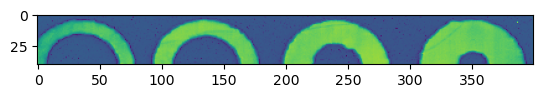

In [5]:
E_amp = model.train_parameters[0].detach().cpu().numpy()
E_amp = E_amp.reshape(-1, width)
plt.imshow(E_amp)

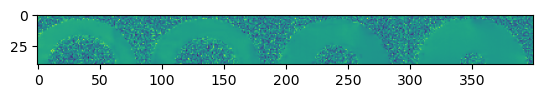

In [6]:
E_pos = model.train_parameters[1].detach().cpu().numpy()
E_pos = E_pos.reshape(-1, width)
plt.imshow(E_pos)